In [1]:
!pip install opencv-python numpy matplotlib torch ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

TASK 1: DETECTION SUMMARY ENGINE
Loading yolov8x.pt model...
Model loaded successfully! Confidence threshold: 0.5
Video Properties:
  Duration: 18.56 seconds
  Total Frames: 465
  Resolution: 1280x720
  FPS: 25.05387931034483
Processing every 5th frame...

Video processing complete!
Total frames processed: 93
Per-frame detection results saved to task1_output/frame_detections.json


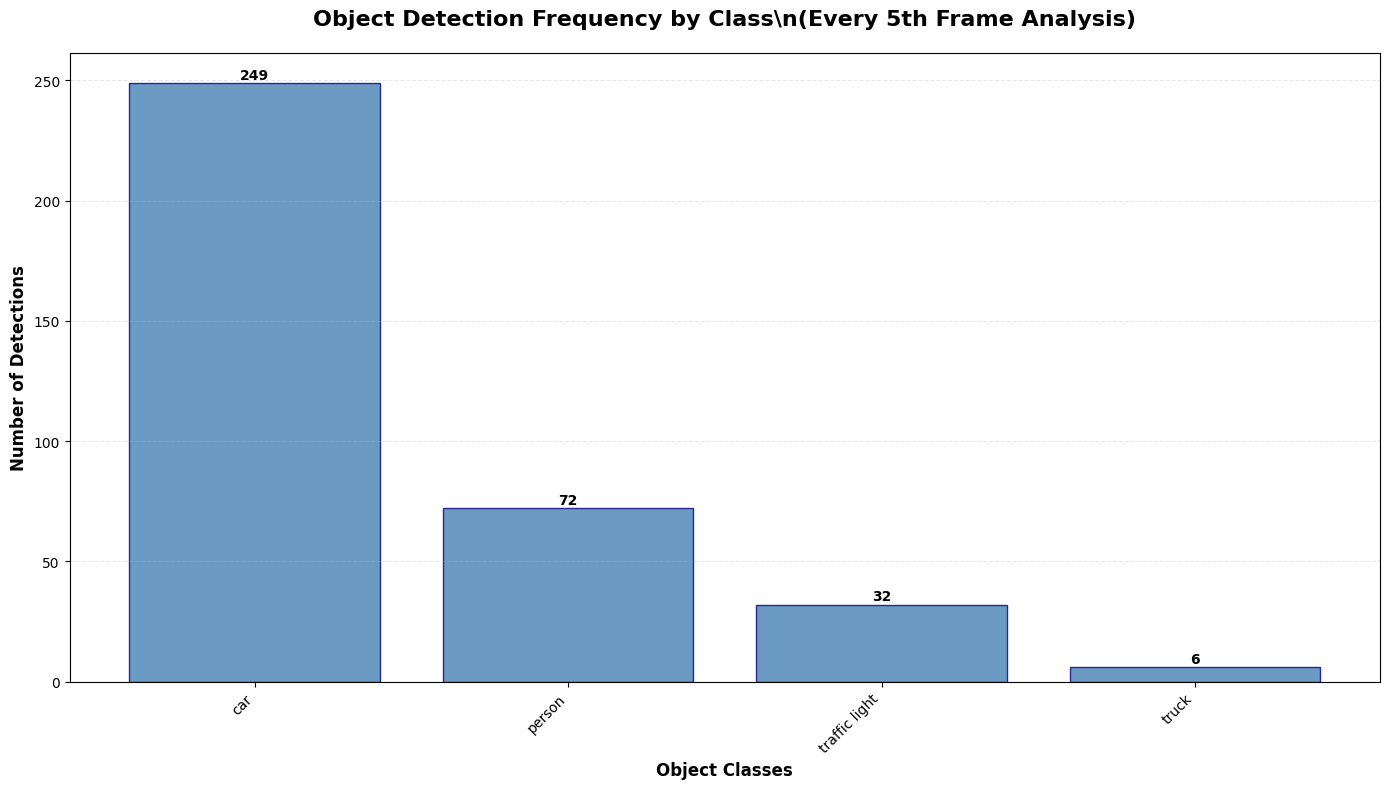

✓ Saved visualization to: task1_output/object_frequency_chart.png

TASK 1 COMPLETED SUCCESSFULLY!

Generated Files:
  📁 task1_outputs/
    📄 frame_detections.json - Per-frame detection results
    📊 object_frequency_chart.png - Frequency visualization
    📁 annotated_frames/ - Annotated frame images


In [6]:
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from pathlib import Path
import time

from ultralytics import YOLO

class DetectionSummaryEngine:

    def __init__(self, model_name='yolov8x.pt', confidence_threshold=0.5):
        print(f"Loading {model_name} model...")
        self.model = YOLO(model_name)
        self.confidence_threshold = confidence_threshold
        self.class_names = self.model.model.names
        self.frame_results = []
        print(f"Model loaded successfully! Confidence threshold: {confidence_threshold}")

    def process_video(self, video_path, output_dir='outputs', save_annotated_frames=False):
        Path(output_dir).mkdir(exist_ok=True)

        cap = cv2.VideoCapture(video_path)

        if not cap.isOpened():
            raise ValueError(f"Error opening video file: {video_path}")

        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = total_frames / fps

        if not 15 <= (duration) <= 20:
            raise ValueError("Video duration must be 15-20 seconds")

        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        print(f"Video Properties:")
        print(f"  Duration: {duration:.2f} seconds")
        print(f"  Total Frames: {total_frames}")
        print(f"  Resolution: {width}x{height}")
        print(f"  FPS: {fps}")
        print(f"Processing every 5th frame...")

        frame_count = 0
        processed_frames = 0

        if save_annotated_frames:
            annotated_dir = Path(output_dir) / 'annotated_frames'
            annotated_dir.mkdir(exist_ok=True)

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Process every 5th frame
            if frame_count % 5 == 0:
                timestamp = frame_count / fps
                detections = self._detect_objects(frame, frame_count, timestamp)

                self.frame_results.append(detections)

                # Optional: Save annotated frame
                if save_annotated_frames and detections['detections']:
                    annotated_frame = self._annotate_frame(frame, detections['detections'])
                    frame_filename = f"frame_{frame_count:04d}.jpg"
                    cv2.imwrite(str(annotated_dir / frame_filename), annotated_frame)

                processed_frames += 1

            frame_count += 1

        cap.release()

        print(f"\nVideo processing complete!")
        print(f"Total frames processed: {len(self.frame_results)}")

        self._save_json_results(output_dir)

        self._create_visualizations(output_dir)

        return self.frame_results

    def _detect_objects(self, frame, frame_number, timestamp):
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = self.model.predict(rgb_frame, conf=self.confidence_threshold, verbose=False)
        detections = []

        for r in results:
            boxes = r.boxes
            for box in boxes:
                x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                conf = float(box.conf[0].cpu().numpy())
                class_id = int(box.cls[0].cpu().numpy())
                if conf < self.confidence_threshold:
                    continue
                detection_dict = {
                    'class_name': self.class_names[class_id],
                    'bbox': {
                        'x1': float(x1),
                        'y1': float(y1),
                        'x2': float(x2),
                        'y2': float(y2)
                    },
                    'confidence': conf
                }
                detections.append(detection_dict)

        frame_data = {
            'frame_number': frame_number,
            'detections': detections
        }

        return frame_data

    def _annotate_frame(self, frame, detections):
        annotated_frame = frame.copy()

        for detection in detections:
            bbox = detection['bbox']
            class_name = detection['class_name']
            confidence = detection['confidence']

            # Draw bounding box
            x1, y1 = int(bbox['x1']), int(bbox['y1'])
            x2, y2 = int(bbox['x2']), int(bbox['y2'])

            cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # Add label
            label = f"{class_name}: {confidence:.2f}"
            label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
            cv2.rectangle(annotated_frame, (x1, y1 - label_size[1] - 10),
                         (x1 + label_size[0], y1), (0, 255, 0), -1)
            cv2.putText(annotated_frame, label, (x1, y1 - 5),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)
        return annotated_frame

    def _save_json_results(self, output_dir):
        output_path = Path(output_dir) / "frame_detections.json"
        with open(output_path, "w") as f:
            json.dump(self.frame_results, f, indent=2)
        print(f"Per-frame detection results saved to {output_path}")

    def _create_visualizations(self, output_dir):
        """Create bar chart visualization of object frequency"""
        # Count objects per class
        class_counts = defaultdict(int)
        for frame_data in self.frame_results:
            for detection in frame_data['detections']:
                class_counts[detection['class_name']] += 1

        if not class_counts:
            print("No objects detected for visualization")
            return

        # Create bar chart
        plt.figure(figsize=(14, 8))
        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        # Sort by count for better visualization
        sorted_data = sorted(zip(classes, counts), key=lambda x: x[1], reverse=True)
        classes, counts = zip(*sorted_data)

        bars = plt.bar(classes, counts, color='steelblue', edgecolor='navy', alpha=0.8)

        # Add value labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    str(count), ha='center', va='bottom', fontweight='bold', fontsize=10)

        plt.title('Object Detection Frequency by Class\\n(Every 5th Frame Analysis)',
                 fontsize=16, fontweight='bold', pad=20)
        plt.xlabel('Object Classes', fontsize=12, fontweight='bold')
        plt.ylabel('Number of Detections', fontsize=12, fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3, linestyle='--')

        plt.tight_layout()

        # Save plot
        plot_path = Path(output_dir) / 'object_frequency_chart.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()

        print(f"✓ Saved visualization to: {plot_path}")

def main():
    """Main function to run Task 1"""
    print("=" * 60)
    print("TASK 1: DETECTION SUMMARY ENGINE")
    print("=" * 60)

    # Configuration
    video_path = "/content/Traffic_Video.mp4"  # Replace with your 15-20 second video
    model_name = "yolov8x.pt"
    confidence_threshold = 0.5
    save_annotated = True

    try:
        engine = DetectionSummaryEngine(
            model_name=model_name,
            confidence_threshold=confidence_threshold
        )

        results = engine.process_video(
            video_path,
            output_dir='task1_output',
            save_annotated_frames=save_annotated
        )

        print("\n" + "=" * 60)
        print("TASK 1 COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print("\nGenerated Files:")
        print("  📁 task1_outputs/")
        print("    📄 frame_detections.json - Per-frame detection results")
        print("    📊 object_frequency_chart.png - Frequency visualization")
        if save_annotated:
            print("    📁 annotated_frames/ - Annotated frame images")

    except Exception as e:
        print(f"Error: {e}")
        print("Please ensure you have a valid video file and required dependencies installed.")

if __name__ == "__main__":
    main()
